In [ ]:
import kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

chip = kbench.Chip(6)

In [68]:
channel = 17
current = 30 # mA
tension = 30 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [61]:
chip.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:6553\t>> Channel 17-17 set to 6553'

In [64]:
chip.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:49151\t>> Channel 17-17 set to 49151'

In [56]:
chip.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 18.728V, 25.067mA'

In [ ]:
def crop_frames(datacube, crop_coords):
    """
    Crop frames in a datacube.
    The datacube must be of at least 3 dimensions.

    Parameters
    ----------
    datacube : nd-array
        Datacube to crop.
    crop_coords : list-like
        Coordinates to crop.

    Returns
    -------
    cropped_cube : nd-array
        Cropped datacube of shape(..., nb of regions, y-size of subframes, x-size of subframes).

    """
    crop_coords = np.array(crop_coords)
    datacube_t = np.transpose(datacube) # Put frames on the first 2 axes
    
    cropped_cube = []
    for i in range(crop_coords.shape[0]):
        cropx, cropy = crop_coords[i]
        out = datacube_t[cropx[0]:cropx[1],cropy[0]:cropy[1]]
        cropped_cube.append(out)
        
    cropped_cube = np.array(cropped_cube)
    cropped_cube = np.transpose(cropped_cube) # Revert to original axes order
    cropped_cube = np.moveaxis(cropped_cube, [-3, -2, -1], [-2, -1, -3]) # Put frames on the last 2 axes
    
    return cropped_cube

crop_size = 10 # px window around the output
crop_centers = np.array([(594, 114),
                        (499, 90),
                        (404, 66),
                        (309, 42),
                        (197, 346)])

crop_coords = [((crop_centers[0,0]-crop_size//2, crop_centers[0,0]+crop_size//2+1), (crop_centers[0,1]-crop_size//2, crop_centers[0,1]+crop_size//2+1)), 
               ((crop_centers[1,0]-crop_size//2, crop_centers[1,0]+crop_size//2+1), (crop_centers[1,1]-crop_size//2, crop_centers[1,1]+crop_size//2+1)),
               ((crop_centers[2,0]-crop_size//2, crop_centers[2,0]+crop_size//2+1), (crop_centers[2,1]-crop_size//2, crop_centers[2,1]+crop_size//2+1)),
               ((crop_centers[3,0]-crop_size//2, crop_centers[3,0]+crop_size//2+1), (crop_centers[3,1]-crop_size//2, crop_centers[3,1]+crop_size//2+1))] # [((x1, x2), (y1, y2))]*4


In [71]:
def get_frame(cam, semid):
    """
    Grab frame from the shared memory and correct for the dark.
    It uses the semaphores to take the frame right after a tip-tilt
    position is send to the DM.

    Parameters
    ----------
    cam : obj
        Shared memory instance of the camera.
    semid : int
        Semaphore value.

    Returns
    -------
    img : 2d-array
        Frame corrected from dark.

    """
    img = cam.get_latest_data(semid)
    
    return img

cam = shm('/dev/shm/cred1.im.shm', nosem=False) # the source of data
semid = 0
cam.catch_up_with_sem(semid)

dk = shm('/dev/shm/cred3_dark.im.shm')
dark = dk.get_latest_data()

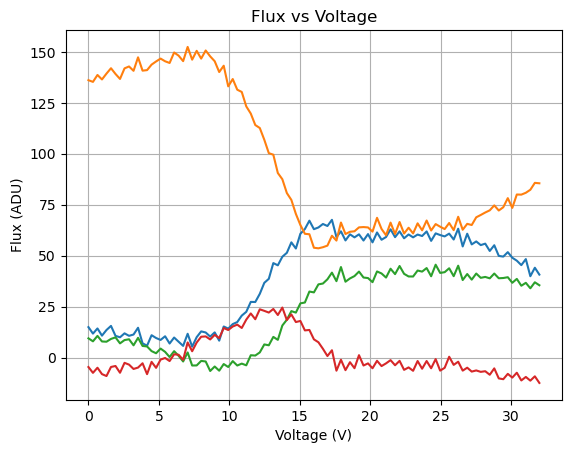

In [84]:
sleep(10)
wait = 0.001
ramp = np.linspace(0, 32, 101)
datacube = []
channel = 17
for v in ramp:
    VOLT = v * 65535 / 40
    #chip.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")
    chip.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")
    sleep(wait)
    #print(chip.send_command(f"CH:{channel}:VAL?"))
    img0 = get_frame(cam, semid)
    img0 = img0 - dark
    datacube.append(img0)

datacube = np.array(datacube)
cropped_cube = crop_frames(datacube, crop_coords)
flux = np.mean(cropped_cube, axis=(-1, -2))

plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Voltage (V)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Voltage")
plt.grid()
plt.show()

In [82]:
print(cropped_cube.shape)

(101, 4, 11, 11)
